# Chạy thử cv2.warpPerspective

In [80]:
import numpy as np
import cv2
import gdown
import matplotlib.pyplot as plt

Downloading...
From: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTU62Md2yC4lIg8Mt_ZUGEVBaoXR7apfYbWbQ&usqp=CAU
To: c:\Users\Lenovo\Downloads\img.png
100%|██████████| 6.24k/6.24k [00:00<00:00, 6.20MB/s]


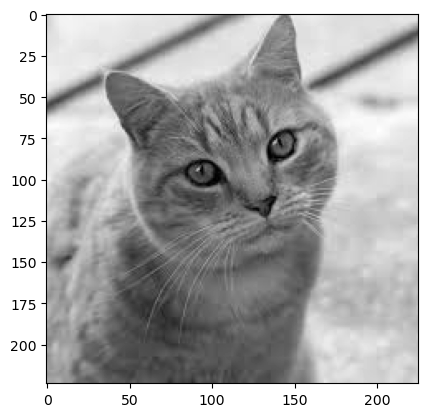

In [81]:
gdown.download('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTU62Md2yC4lIg8Mt_ZUGEVBaoXR7apfYbWbQ&usqp=CAU', output = "img.png")
img_path = "img.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.show()

In [82]:
img.shape

(224, 225)

In [83]:
in_points = np.float32([[0,0], [223,0], [0,224], [223,224]])
out_points = np.float32([[10,10], [218,20], [20,204], [198,184]])

M = cv2.getPerspectiveTransform(in_points, out_points)


In [84]:
M

array([[1.13441701e+00, 6.17607073e-02, 1.00000000e+01],
       [6.33459469e-02, 1.04067350e+00, 1.00000000e+01],
       [9.25144877e-04, 8.55892510e-04, 1.00000000e+00]])

In [85]:
out_img = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

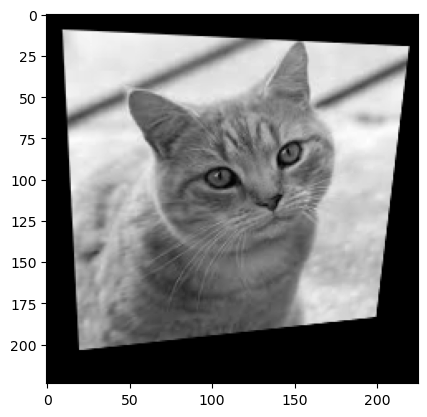

In [86]:
plt.imshow(out_img, cmap='gray')
plt.show()

# Hiện thực hàm getPerspectiveTransform

In [87]:
def my_get_perspective_transform(ips, ops):
    ips = np.float32(ips)
    ops = np.float32(ops)
    A = np.ones((8, 8))
    b = np.ones((8, 1))
    for k in range(0, 4):
        A[2*k] = [ips[k][0], ips[k][1], 1, 0, 0, 0, -ips[k][0] * ops[k][0], -ips[k][1] * ops[k][0]]
        A[2*k+1] = [0, 0, 0, ips[k][0], ips[k][1], 1, -ips[k][0] * ops[k][1], -ips[k][1] * ops[k][1]]
        b[2*k] = ops[k][0]
        b[2*k+1] = ops[k][1]
    mat_res = np.linalg.solve(A, b)
    mat_res = np.append(mat_res, 1)
    return mat_res.reshape(3, 3)

my_matrix = my_get_perspective_transform(in_points, out_points)
my_matrix
    

array([[1.13441701e+00, 6.17607073e-02, 1.00000000e+01],
       [6.33459469e-02, 1.04067350e+00, 1.00000000e+01],
       [9.25144877e-04, 8.55892510e-04, 1.00000000e+00]])

In [88]:
#M là matrix tạo bởi cv2.getPerspectiveTransform
#So sánh với my_matrix
my_matrix - M 

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.38777878e-17,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

# Hiện thực hàm warpAffine (dùng backward mapping và bilinear interpolation)

In [89]:
def inter_bilinear(img, x, y):
    delta_x = x - int(x)
    delta_y = y - int(y)
    x_0 = int(x)
    y_0 = int(y)
    x_1 = x_0 if x_0 == img.shape[1] - 1 else x_0 + 1
    y_1 = y_0 if y_0 == img.shape[0] - 1 else y_0 + 1
    P_00 = img[y_0][x_0]
    P_01 = img[y_0][x_1]
    P_10 = img[y_1][x_0]
    P_11 = img[y_1][x_1]
    return P_00 * (1 - delta_x) * (1 - delta_y) + P_01 * delta_x * (1 - delta_y) + P_10 * (1 - delta_x) * delta_y + P_11 * delta_x * delta_y

In [90]:
def my_backward_warp_perspective(img, M):
    out_img = np.zeros(img.shape)
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            inv_M = np.linalg.inv(M)
            Q = np.array([j, i, 1], dtype=np.float32)
            Q = Q.reshape(3, 1)
            P = np.dot(inv_M, Q)
            P = P / P[2]
            if (P[0] < 0 or P[0] >= img.shape[1] or P[1] < 0 or P[1] >= img.shape[0]):
                out_img[i][j] = 0
            else:
                out_img[i][j] = inter_bilinear(img, P[0], P[1])
    return out_img

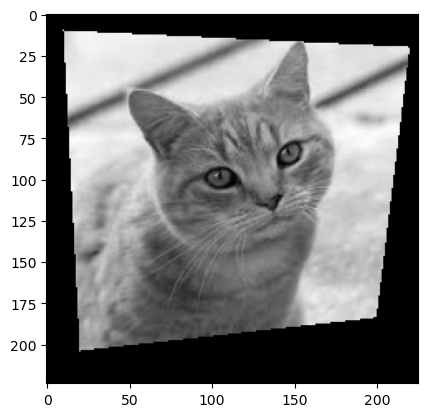

In [91]:
my_out_img = my_backward_warp_perspective(img, M)
plt.imshow(my_out_img, cmap='gray')
plt.show()

# Hiện thực backward polar transform 


In [92]:
gdown.download('https://www.shutterstock.com/image-vector/vector-eye-closeup-human-on-260nw-1888361227.jpg', output = 'eye.png')

Downloading...
From: https://www.shutterstock.com/image-vector/vector-eye-closeup-human-on-260nw-1888361227.jpg
To: c:\Users\Lenovo\Downloads\eye.png
100%|██████████| 18.2k/18.2k [00:00<00:00, 18.3MB/s]


'eye.png'

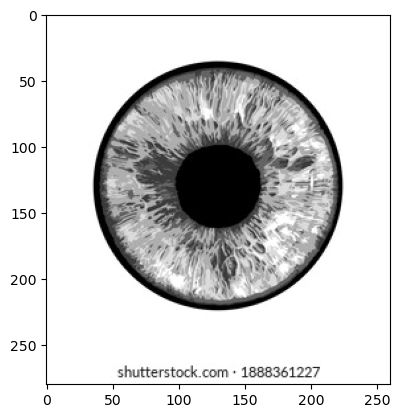

In [93]:
eye_img = cv2.imread('eye.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(eye_img, cmap='gray')

In [96]:
def backward_polar_transform(img, r_max, r_min, theta_max, theta_min, delta_r, delta_theta):
    num_r = int((r_max - r_min) / delta_r)
    num_theta = int((theta_max - theta_min) / delta_theta)
    out_img = np.zeros((num_r, num_theta))
    for i in range(0, num_r):
        for j in range(0, num_theta):
            r = r_min + i * delta_r
            theta = theta_min + j * delta_theta
            x = r * np.cos(theta)
            y = r * np.sin(theta)
            x += img.shape[1] / 2
            y += img.shape[0] / 2
            if (x < 0 or x >= img.shape[1] or y < 0 or y >= img.shape[0]):
                out_img[i][j] = 0
            else:
                out_img[i][j] = inter_bilinear(img, x, y)
    return out_img

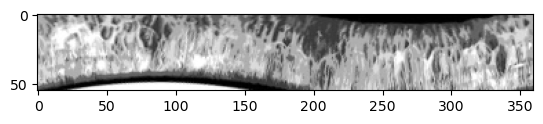

In [97]:
pl_img = backward_polar_transform(eye_img, 90, 35, 2 * np.pi, 0, 1, np.pi / 180)
plt.imshow(pl_img, cmap='gray')